In [1]:
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
import cartopy as cy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import datetime as dt

from geopy import distance
import math
import re

In [2]:
 yesterday_date = dt.datetime.now() - dt.timedelta(days=1)

In [3]:
# ty toget latest forecast for 6 am orthe day before 
OPeNDAP_url = f'https://thredds.met.no/thredds/dodsC/fou-hi/mywavewam3_latest/MyWave_wam3_SPC_{dt.datetime.now().strftime("%Y%m%d")}T06Z.nc'
try: 
    ds =  xr.open_dataset(OPeNDAP_url)
except OSError as e:
    print(f"An OS error occurred: {e}")
    yesterday_date = dt.datetime.now() - dt.timedelta(days=1)
    OPeNDAP_url = f'https://thredds.met.no/thredds/dodsC/fou-hi/mywavewam3_latest/MyWave_wam3_SPC_{yesterday_date.strftime("%Y%m%d")}T06Z.nc'
    ds =  xr.open_dataset(OPeNDAP_url)
ds

An OS error occurred: [Errno -90] NetCDF: file not found: 'https://thredds.met.no/thredds/dodsC/fou-hi/mywavewam3_latest/MyWave_wam3_SPC_20241223T06Z.nc'


<xarray.Dataset> Size: 387MB
Dimensions:                  (direction: 36, freq: 29, x: 693, y: 1, time: 133)
Coordinates:
  * direction                (direction) float32 144B 5.0 15.0 ... 345.0 355.0
  * freq                     (freq) float32 116B 0.03452 0.03798 ... 0.4979
  * x                        (x) int32 3kB 1 2 3 4 5 6 ... 689 690 691 692 693
  * y                        (y) int32 4B 1
  * time                     (time) datetime64[ns] 1kB 2024-12-21T12:00:00 .....
    latitude                 (y, x) float32 3kB ...
    longitude                (y, x) float32 3kB ...
Data variables:
    forecast_reference_time  datetime64[ns] 8B ...
    SPEC                     (time, y, x, freq, direction) float32 385MB ...
    Pdir                     (time, y, x) float32 369kB ...
    dd                       (time, y, x) float32 369kB ...
    ff                       (time, y, x) float32 369kB ...
    hs                       (time, y, x) float32 369kB ...
    model_depth              (y, x) float32 3kB ...
    thq_sea                  (time, y, x) float32 369kB ...
    thq_swell                (time, y, x) float32 369kB ...
    tp                       (time, y, x) float32 369kB ...
Attributes:
    title:                           WINDSURFER/NORA3, hindcast hourly 2D wav...
    institution:                     Norwegian Meteorological Institute
    source:                          WAM wave model version cycle 4.7.0
    direction_convention:            A direction of 0 degrees means a wave pr...
    history:                         Sun Dec 22 11:07:01 2024: ncks -A -v for...
    history_of_appended_files:       Sun Dec 22 11:07:01 2024: Appended file ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

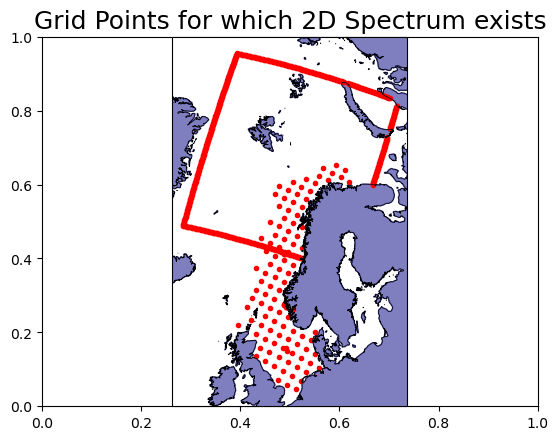

In [4]:
#plot scope of forecast
fig, ax = plt.subplots()
ax = plt.axes(projection=ccrs.Orthographic(-10, 45))
# ax.stock_img()
ax.add_feature(cfeature.LAND,color='navy', alpha = 0.5)
#ax.add_feature(cfeature.LAKES)
ax.coastlines(resolution='10m', color='black', linewidth=0.5)
ax.scatter(ds.longitude,ds.latitude,marker='.', color='red',transform=ccrs.PlateCarree())
plt.title('Grid Points for which 2D Spectrum exists',fontsize=18)
plt.show()

# I am interested in Saltstein beach, that's where sensor was deployed  

https://bolge.vps.webdock.cloud:3000/d/ce2qpmjaeldz4f/real-saltstein-data?orgId=1&from=1729951552806&to=1730551056281

In [5]:
#Find grid points within +/ (deltaLlon,delata_lat) range from point of interest
def find_spectrum_grid_points_within_area(point_of_interest_lon, point_of_interest_lat, delta_lat,delta_lon):
    left_limit_lat = round(point_of_interest_lat,1) -delta_lat
    right_limit_lat = round(point_of_interest_lat,1) + delta_lat
    left_limit_lon = round(point_of_interest_lon,1) - delta_lon
    right_limit_lon = round(point_of_interest_lon,1) + delta_lon
    # The spectrum point can be found by x coordinate (y does not change and is misleading)
    lat_indices_x = ds.latitude.where((ds.latitude >= left_limit_lat) & (ds.latitude <= right_limit_lat), drop=True).x
    lon_indices_x = ds.longitude.where((ds.longitude >= left_limit_lon) & (ds.longitude <= right_limit_lon), drop=True).x
    intersection = np.intersect1d(lat_indices_x.values, lon_indices_x.values)
    return intersection
    

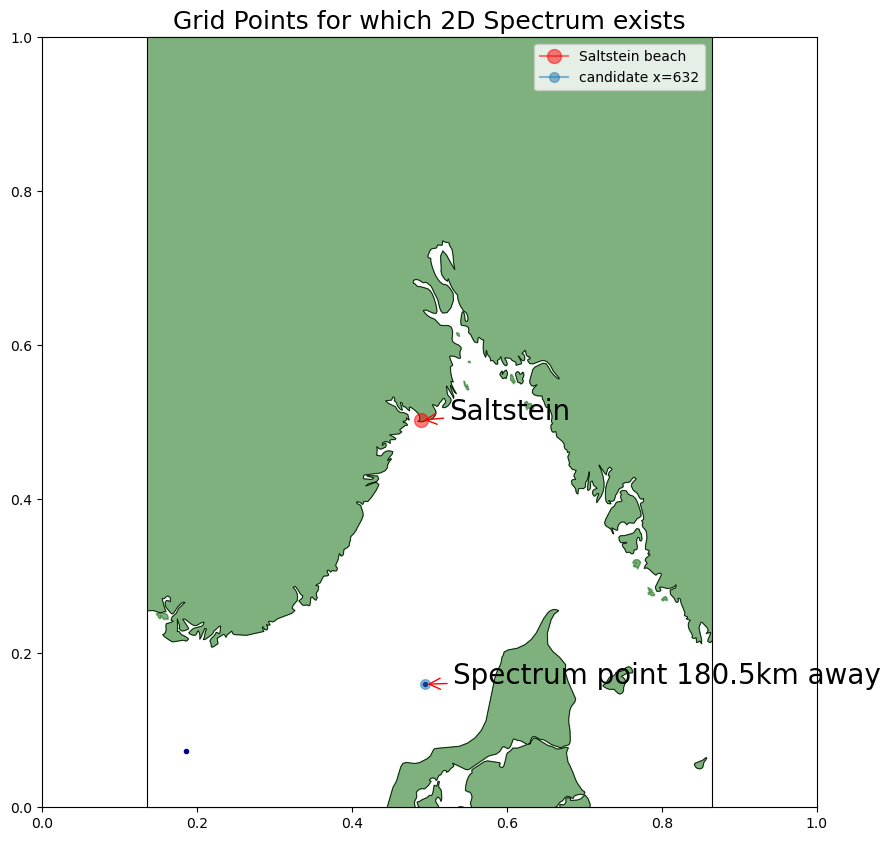

In [6]:
#narrow down for area of interest
salt_lon = 9.850742
salt_lat = 58.965394
salt_coord = (salt_lon, salt_lat)

grid_points = find_spectrum_grid_points_within_area(salt_lon, salt_lat,2, 2)

fig, ax = plt.subplots(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Orthographic(-10, 45))
extend_scope = 2
ax.axes.set_extent([salt_lon - extend_scope, salt_lon + extend_scope, salt_lat - extend_scope , salt_lat + extend_scope], crs=ccrs.PlateCarree())

# Annotate the place
ax.annotate(
    "Saltstein", 
    xy=salt_coord, 
    xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
    xytext=(20, 0),  #
    textcoords='offset points',
    arrowprops=dict(arrowstyle="->", color='red'),
    fontsize=20,
    color='black')

ax.add_feature(cfeature.LAND,color='darkgreen', alpha = 0.5)
ax.coastlines(resolution='10m', color='black', linewidth=0.5)
ax.scatter(ds.longitude,ds.latitude,marker='.', color='navy',transform=ccrs.PlateCarree())
ax.plot(salt_lon, salt_lat, marker='o', color='red', alpha = 0.5, markersize=10, label="Saltstein beach", transform=ccrs.PlateCarree())
for spec_x in grid_points:
    spec_grid_coord = (ds.longitude.sel(x = spec_x).values[0], ds.latitude.sel(x = spec_x).values[0])
    spec_dist = distance.distance(salt_coord,spec_grid_coord)
    ax.plot(ds.longitude.sel(x = spec_x), ds.latitude.sel(x = spec_x), marker='o', alpha = 0.5, markersize=7, label=f"candidate x={spec_x}", transform=ccrs.PlateCarree())
    
    ax.annotate(
        f"Spectrum point {round(spec_dist.km,1)}km away", 
        xy=spec_grid_coord, 
        xycoords=ccrs.PlateCarree()._as_mpl_transform(ax),
        xytext=(20, 0),  #
        textcoords='offset points',
        arrowprops=dict(arrowstyle="->", color='red'),
        fontsize=20,
        color='black'
    )
    ax.legend()
plt.title('Grid Points for which 2D Spectrum exists',fontsize=18)
plt.show()

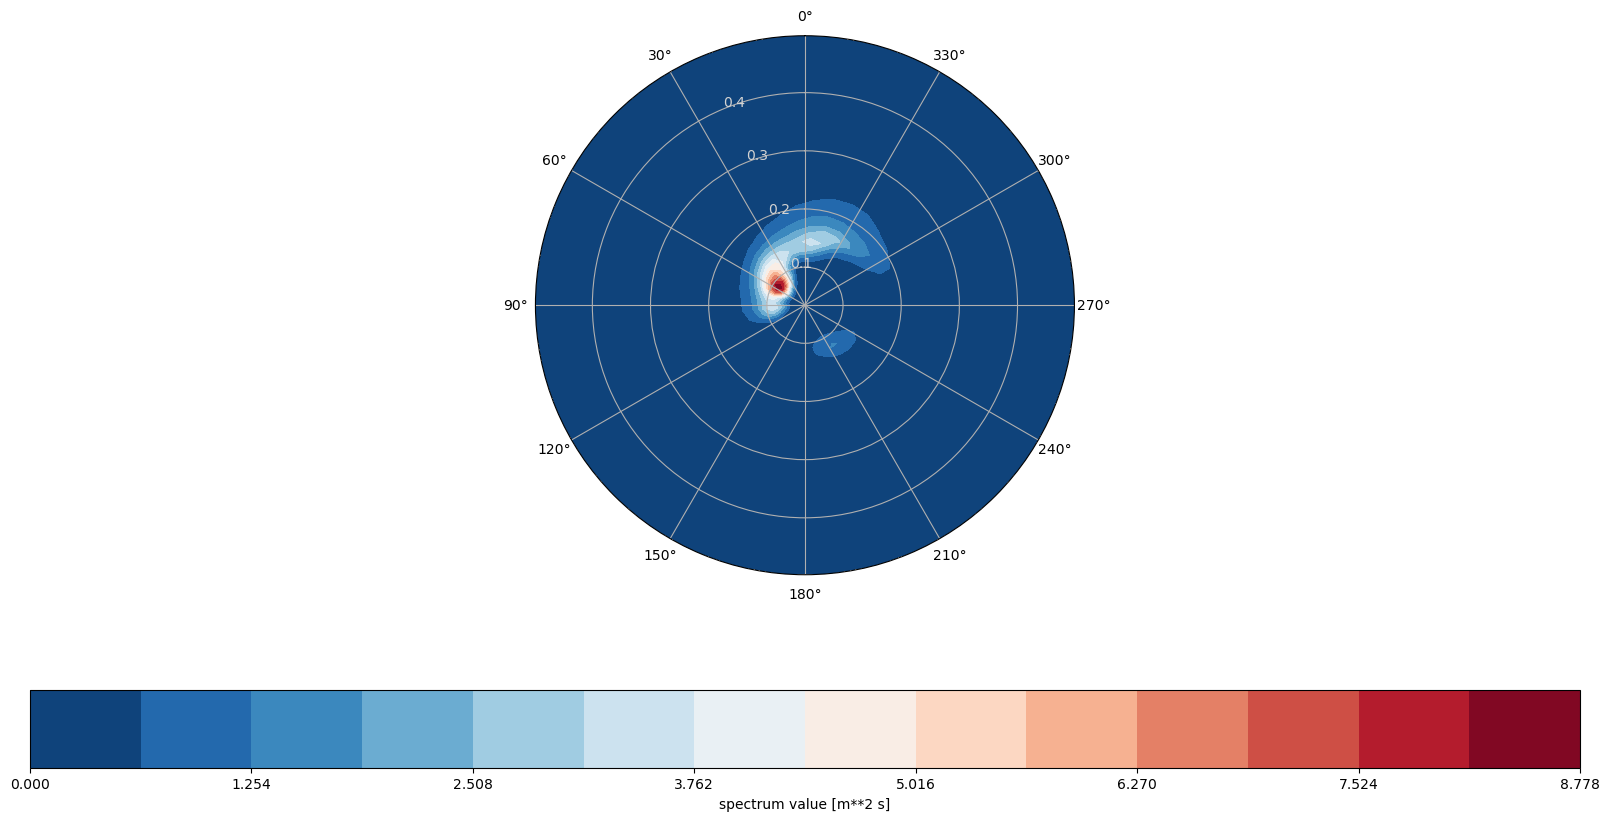

In [7]:
#thetas are 0-360-step angle values expressed in radians thus 0-2pi- step
thetas = [math.radians(deg) for deg in ds.direction.values]
#frequencies are discrete frequencies - equvanet to 1.03 - 28.9 s periods
freqencies = ds.freq.values
time_index = 0
#since SPEC is 2d matrix: freq, direction I need to transpose it to plot on polar plot
E = ds.isel(time = time_index,  x = spec_x, y = 0)['SPEC'].values.T
# since thetas are not exactly from 0 to 360, extra step must be added, otherwise the spectrum plot would be wedged
dtheta = np.diff(thetas).mean() # / theta step, they are rather equal
wrapped_theta = np.concatenate((thetas, thetas[-1:] + dtheta))
wrapped_E = np.concatenate((E, E[0:1, :]), axis=0)

#generating meshgrid
[r_coord, th_coord] = np.meshgrid(freqencies,wrapped_theta)

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, polar = True)
#beautifying the polar plot 
ax.set_theta_zero_location('N')
ax.set_theta_direction(+1)
ax.tick_params(axis='y', labelcolor='lightgrey', colors='lightgrey')

ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))

cntf = ax.contourf(th_coord, r_coord, wrapped_E, cmap='RdBu_r', 
                   levels=np.linspace(np.min(E), np.max(E), 15))

_ = fig.colorbar(cntf, ax=ax, orientation='horizontal', label='spectrum value [m**2 s]')

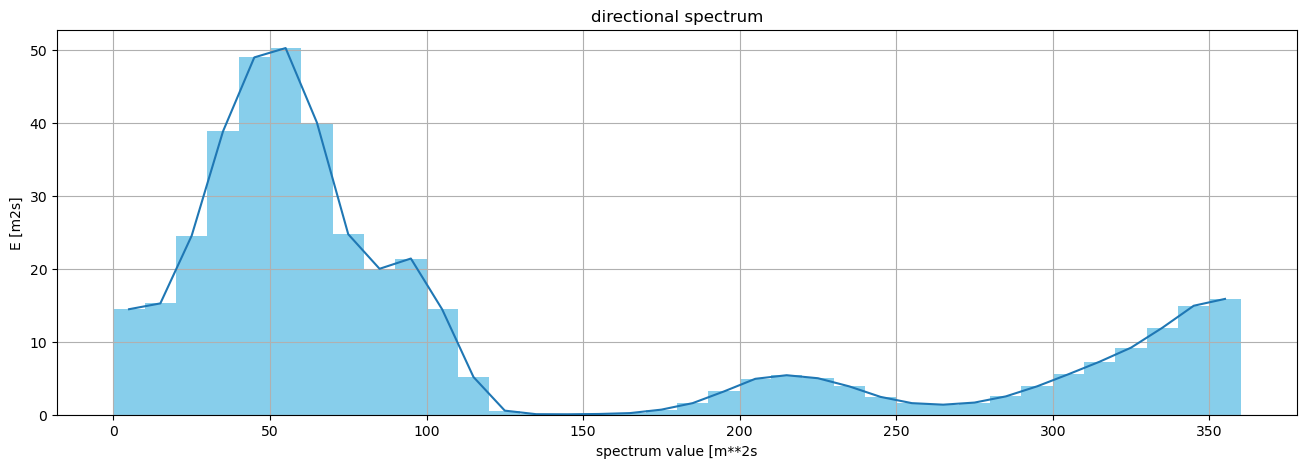

In [8]:
fig, (ax) = plt.subplots(1, 1, figsize=(16, 5)) 
E = ds.isel(time = time_index,  x = spec_x, y = 0)['SPEC'].values
energy_sum_by_deg = np.sum(E, axis=0)
ax.bar(ds.direction.values, energy_sum_by_deg, width=10, color = 'skyblue')  
ax.plot(ds.direction.values, energy_sum_by_deg)

#ax.fill_between(ds.direction.values, deg_total_energy, color="skyblue", alpha=0.4)
ax.set_title("directional spectrum")
ax.set_xlabel("direction [degrees]")
ax.set_xlabel("spectrum value [m**2s")
ax.set_ylabel("E [m2s]")
ax.grid(True)

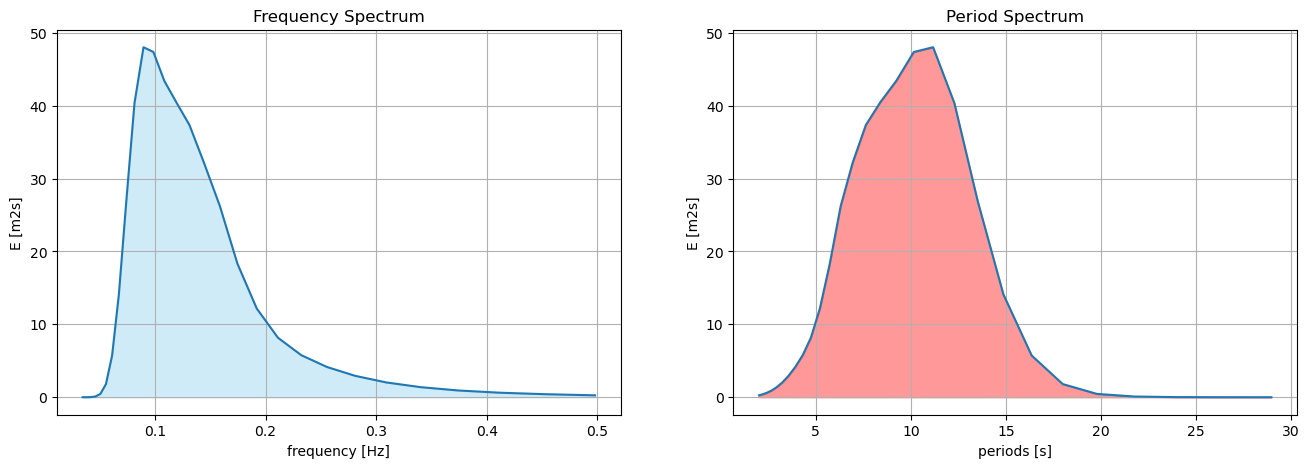

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5)) 
energy_sum_by_freq = np.sum(E, axis=1)
ax1.plot(ds.freq.values, energy_sum_by_freq)
ax1.fill_between(ds.freq.values, energy_sum_by_freq, color="skyblue", alpha=0.4)
ax1.set_title("Frequency Spectrum")
ax1.set_ylabel("E [m2s]")
ax1.set_xlabel("frequency [Hz]")
ax1.grid(True)

periods = 1/ds.freq.values
ax2.set_ylabel("E [m2s]")
ax2.set_title("Period Spectrum")
ax2.set_xlabel("periods [s]")
ax2.plot(periods, energy_sum_by_freq)
ax2.fill_between(periods, energy_sum_by_freq, color="red", alpha=0.4)
ax2.grid(True)
